In [22]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd

from src.paths import PREPROCESSED_DATA_DIR

In [24]:
df_weather = pd.read_pickle(PREPROCESSED_DATA_DIR / 'aggregated_weather.pkl')
df_train = pd.read_pickle(PREPROCESSED_DATA_DIR / 'train.pkl')

In [25]:
df_weather.shape

(1451, 336)

In [26]:
df_train_0 = df_train[df_train.WnvPresent==0].groupby(['Trap', 'Year', 'Month']).sample(frac=0.15, random_state=42)
df_train_1 = df_train[df_train.WnvPresent==1]
df_train = pd.concat([df_train_0, df_train_1])

In [27]:
labels = df_train.pop('WnvPresent')

features = ['Date','Latitude', 'Longitude', 'Species', 'Dayofyear']
# weather_cols = ['DewPoint_1_mean_1_10', 'DewPoint_2_mean_1_10', 
#              'DewPoint_1_mean_11_10', 'DewPoint_2_mean_11_10', 
#              'DewPoint_1_mean_21_10', 'DewPoint_2_mean_21_10',
#              'Tavg_1_mean_1_10', 'Tavg_2_mean_1_10',
#              'Tavg_1_mean_11_10', 'Tavg_2_mean_11_10',
#              'Tavg_1_mean_21_10', 'Tavg_2_mean_21_10',
#              'PrecipTotal_1_sum_1_10', 'PrecipTotal_2_sum_1_10',
#              'PrecipTotal_1_sum_11_10', 'PrecipTotal_2_sum_11_10',
#              'PrecipTotal_1_sum_21_10', 'PrecipTotal_2_sum_21_10']

df_train = pd.merge(df_train[features], df_weather.reset_index(), on='Date')
# df_train =df_train[features]
df_train.drop('Date', axis=1, inplace=True)

In [28]:
labels.mean()

np.float64(0.3397396156230626)

In [36]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

df_new = SelectKBest(f_classif, k=20).fit_transform(df_train, labels)

In [44]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

classifier = LinearSVC(C=0.005, penalty="l1", dual=False).fit(df_train, labels)
model = SelectFromModel(classifier, prefit=True)
df_new = model.transform(df_train)
df_new.shape

/home/aga/repos/west_nile_virus/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/aga/repos/west_nile_virus/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(1613, 106)

In [45]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [40, 50],
    'max_depth': [4, 5, 6],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [1, 10],
    'gamma': [0, 0.5],
    'colsample_bytree': [0.8],
    'min_child_weight': [1, 3]
}

xgb = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
model = GridSearchCV(
    param_grid=param_grid,
    estimator=xgb,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

model.fit(df_new, labels)
best_model = model.best_estimator_

Fitting 15 folds for each of 144 candidates, totalling 2160 fits


In [46]:
print(f'Best_model params: {model.best_params_}')
print(f'Best score: {round(model.best_score_, 4)}')

Best_model params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 40, 'reg_alpha': 0.1, 'reg_lambda': 10}
Best score: 0.7962


<Axes: >

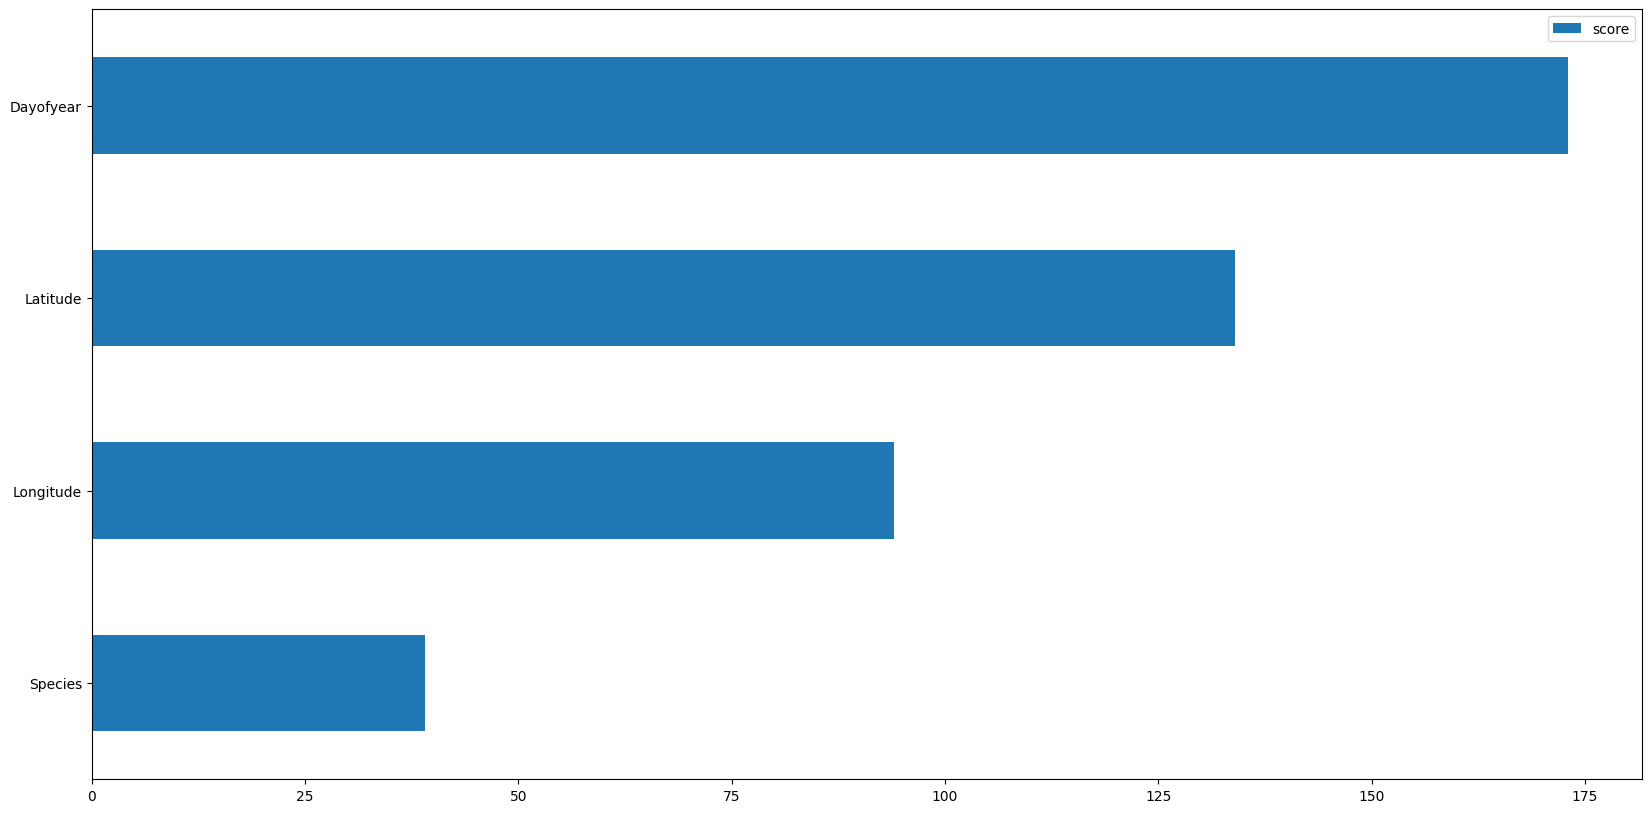

In [19]:
feature_important = best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values("score")
data.plot(kind='barh', figsize = (20,10))